## Hualien Earthquake Project

In [2]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
client = Client('IRIS')

### Seismology

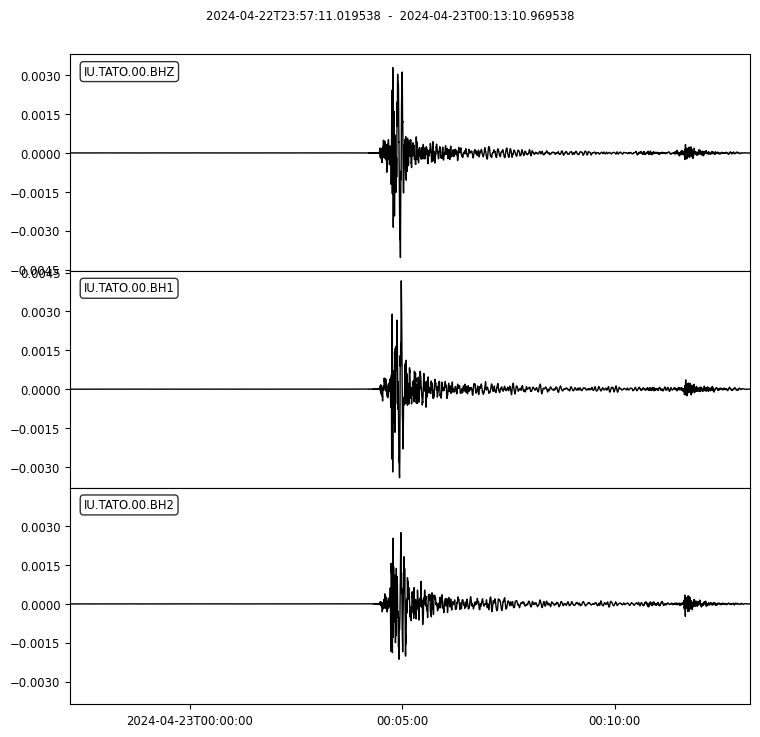

In [9]:
time = UTCDateTime('2024-04-22T23:58:11')
starttime = time - 60
endtime = time + 60*15
net='IU'; sta='TATO'; loc='00'; chan='BH*'
st = client.get_waveforms(net,sta,loc,chan, starttime, endtime, attach_response=True)
st.remove_response(output='VEL')
st.plot();

### Geospatial

In [64]:
import pygmt
import rioxarray
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Taiwan_eq = pd.read_csv('http://raw.githubusercontent.com/Benz-Poobua/ESS_521/main/Taiwan_EQ_archives.csv')

In [6]:
Taiwan_eq

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-04-23T17:12:14.997Z,23.7350,121.5936,7.881,4.0,mwr,44.0,88.0,0.436,0.66,...,2024-04-23T18:15:54.040Z,"26 km S of Hualien City, Taiwan",earthquake,2.90,5.194,0.069,20.0,reviewed,us,us
1,2024-04-23T16:02:21.245Z,24.0619,121.7117,7.473,4.9,mb,122.0,44.0,0.678,0.53,...,2024-04-23T17:00:10.040Z,"14 km NE of Hualien City, Taiwan",earthquake,2.73,3.524,0.053,118.0,reviewed,us,us
2,2024-04-23T12:40:51.668Z,23.7051,121.6597,10.000,4.4,mwr,70.0,39.0,0.456,0.68,...,2024-04-23T14:18:15.040Z,"30 km S of Hualien City, Taiwan",earthquake,5.24,1.651,0.089,12.0,reviewed,us,us
3,2024-04-23T05:08:05.896Z,23.7091,121.6223,10.000,4.7,mb,32.0,89.0,0.434,1.09,...,2024-04-23T05:42:31.040Z,"29 km S of Hualien City, Taiwan",earthquake,2.84,1.903,0.090,37.0,reviewed,us,us
4,2024-04-23T02:21:00.008Z,23.8333,121.6102,10.000,5.2,mwr,67.0,63.0,0.524,0.65,...,2024-04-23T23:47:21.223Z,"15 km S of Hualien City, Taiwan",earthquake,1.77,1.804,0.068,21.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2000-01-21T01:36:24.900Z,24.0600,121.4100,7.600,4.5,ml,NaN,NaN,NaN,NaN,...,2014-11-07T01:09:21.123Z,Taiwan,earthquake,NaN,NaN,NaN,NaN,reviewed,tap,tap
1904,2000-01-20T17:42:11.810Z,23.4770,121.5260,33.000,4.7,mb,NaN,NaN,NaN,1.00,...,2014-11-07T01:09:21.067Z,"55 km S of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,19.0,reviewed,us,us
1905,2000-01-12T03:17:23.670Z,23.2900,121.3620,33.000,3.9,mb,NaN,NaN,NaN,0.87,...,2014-11-07T01:09:19.174Z,"80 km SSW of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,3.0,reviewed,us,us
1906,2000-01-03T22:59:14.830Z,24.0540,121.6240,10.000,NaN,NaN,NaN,NaN,NaN,1.19,...,2014-11-07T01:09:16.977Z,"8 km NNE of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


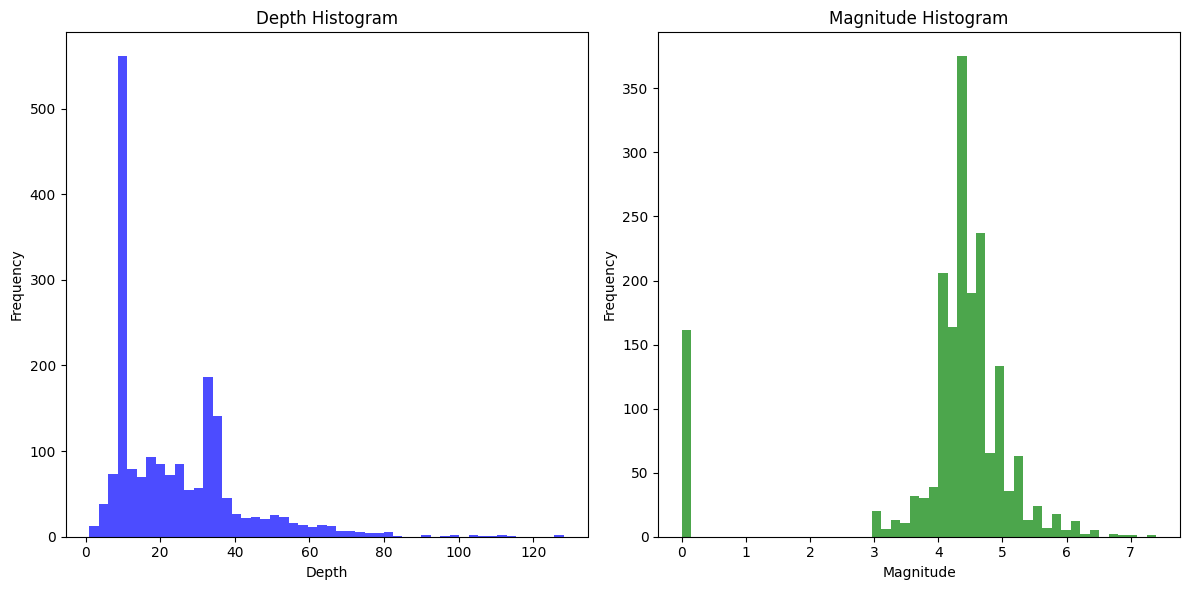

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for 'depth'
axes[0].hist(Taiwan_eq['depth'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Depth Histogram')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Frequency')

# Histogram for 'mag'
axes[1].hist(Taiwan_eq['mag'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Magnitude Histogram')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Frequency')

# Show plot
plt.tight_layout()
plt.show()

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from 120.5 to 120
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 123.1 to 124
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 21.8 to 21
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 25.4 to 26


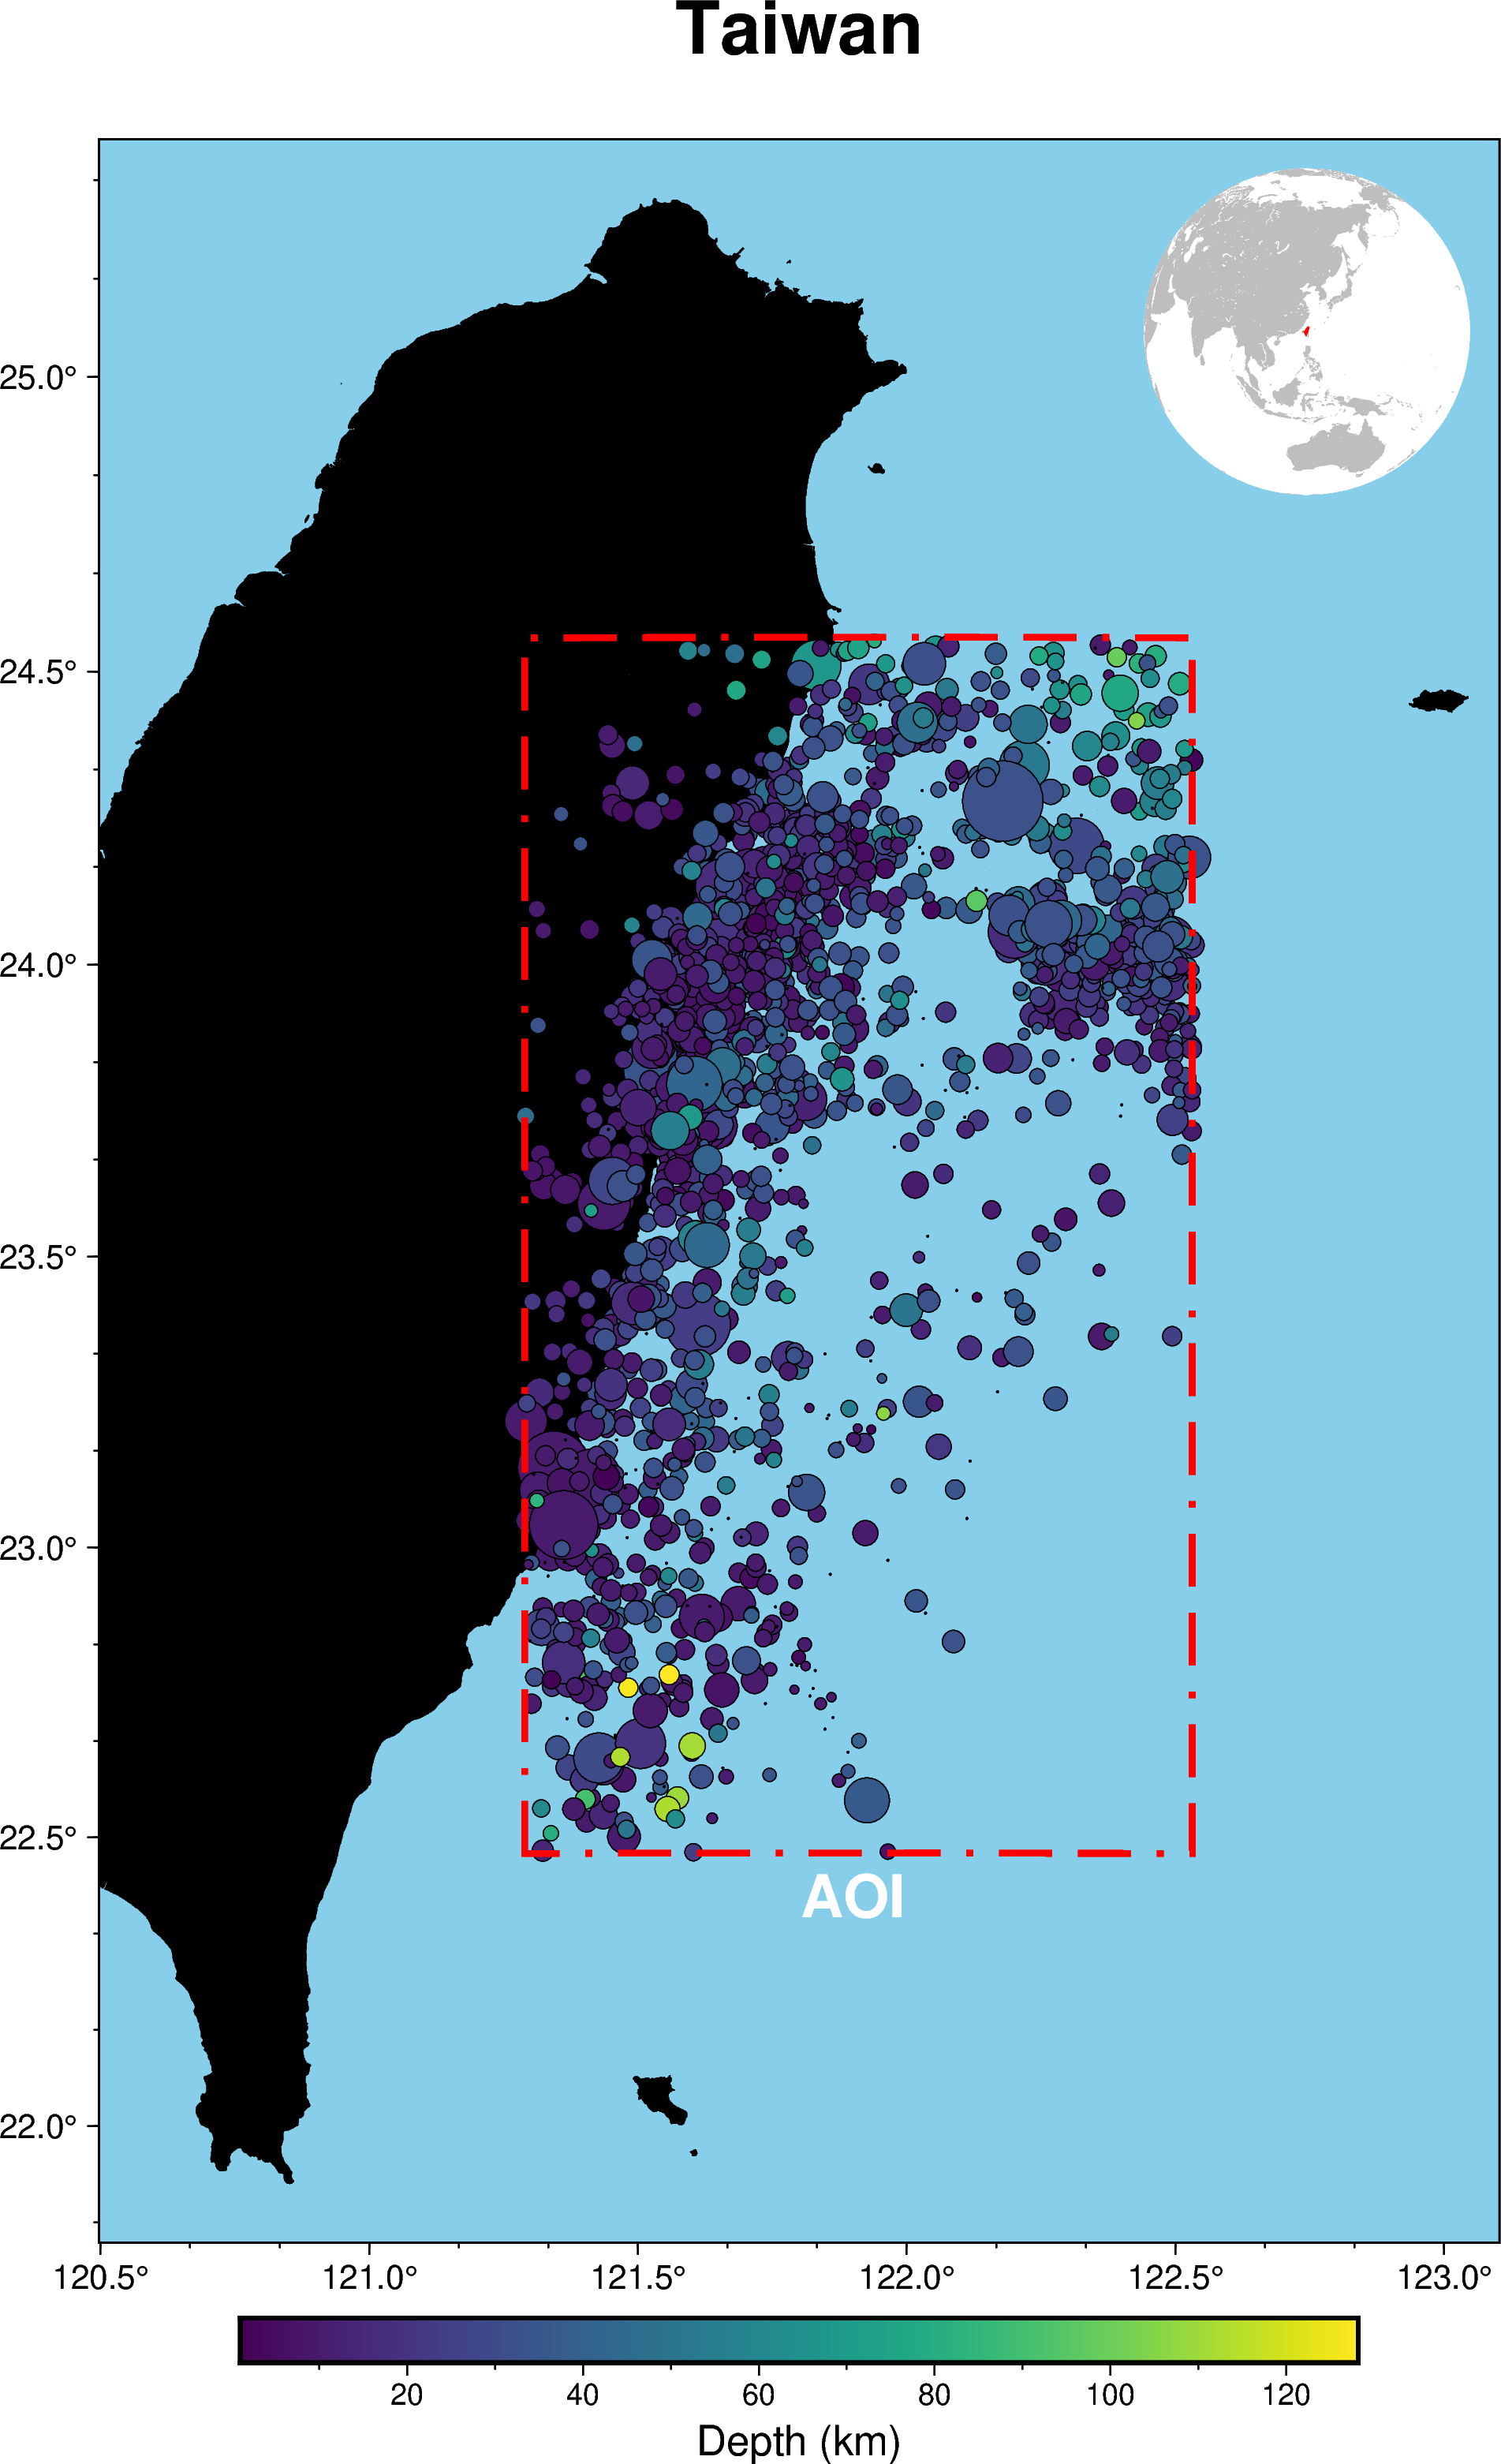

In [81]:
region = [120.5, 123.1, 21.8, 25.4]
grid = pygmt.datasets.load_earth_relief(resolution='01d', region=region)
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.x', MAP_FRAME_TYPE='plain')
fig.basemap(region=region, projection ='M15c',frame=True)
fig.basemap(frame='+tTaiwan')
fig.coast(land='black', water='skyblue', borders=['2/0.5p,red'])
pygmt.makecpt(cmap="viridis", series=[Taiwan_eq['depth'].min(), Taiwan_eq['depth'].max()])
fig.plot(
    x=Taiwan_eq['longitude'],
    y=Taiwan_eq['latitude'], 
    size=0.02*(1.7**Taiwan_eq['mag']), 
    fill=Taiwan_eq['depth'],
    cmap=True, 
    style='cc',
    pen='black')
fig.colorbar(frame="xaf+lDepth (km)")
fig.plot(
    projection="M15c",
    x=[121.289, 121.289, 122.531, 122.531,121.289],
    y=[22.472, 24.557, 24.557, 22.472, 22.472],
    pen="2p,red,-.-",
)
fig.text(text="AOI", x=121.9, y=22.4, font="18p,Helvetica-Bold,white")
with fig.inset(
    position="jTR+w3.5c+o0.3c",
    margin=0):
    fig.coast(region="g",
              projection="G121/23.5/3.5c",
              land="gray",
              water="white",
              dcw="TW+gred"
    )
fig.show()

In [63]:
Taiwan_big_eq = Taiwan_eq[Taiwan_eq['mag'] >= 6.0]

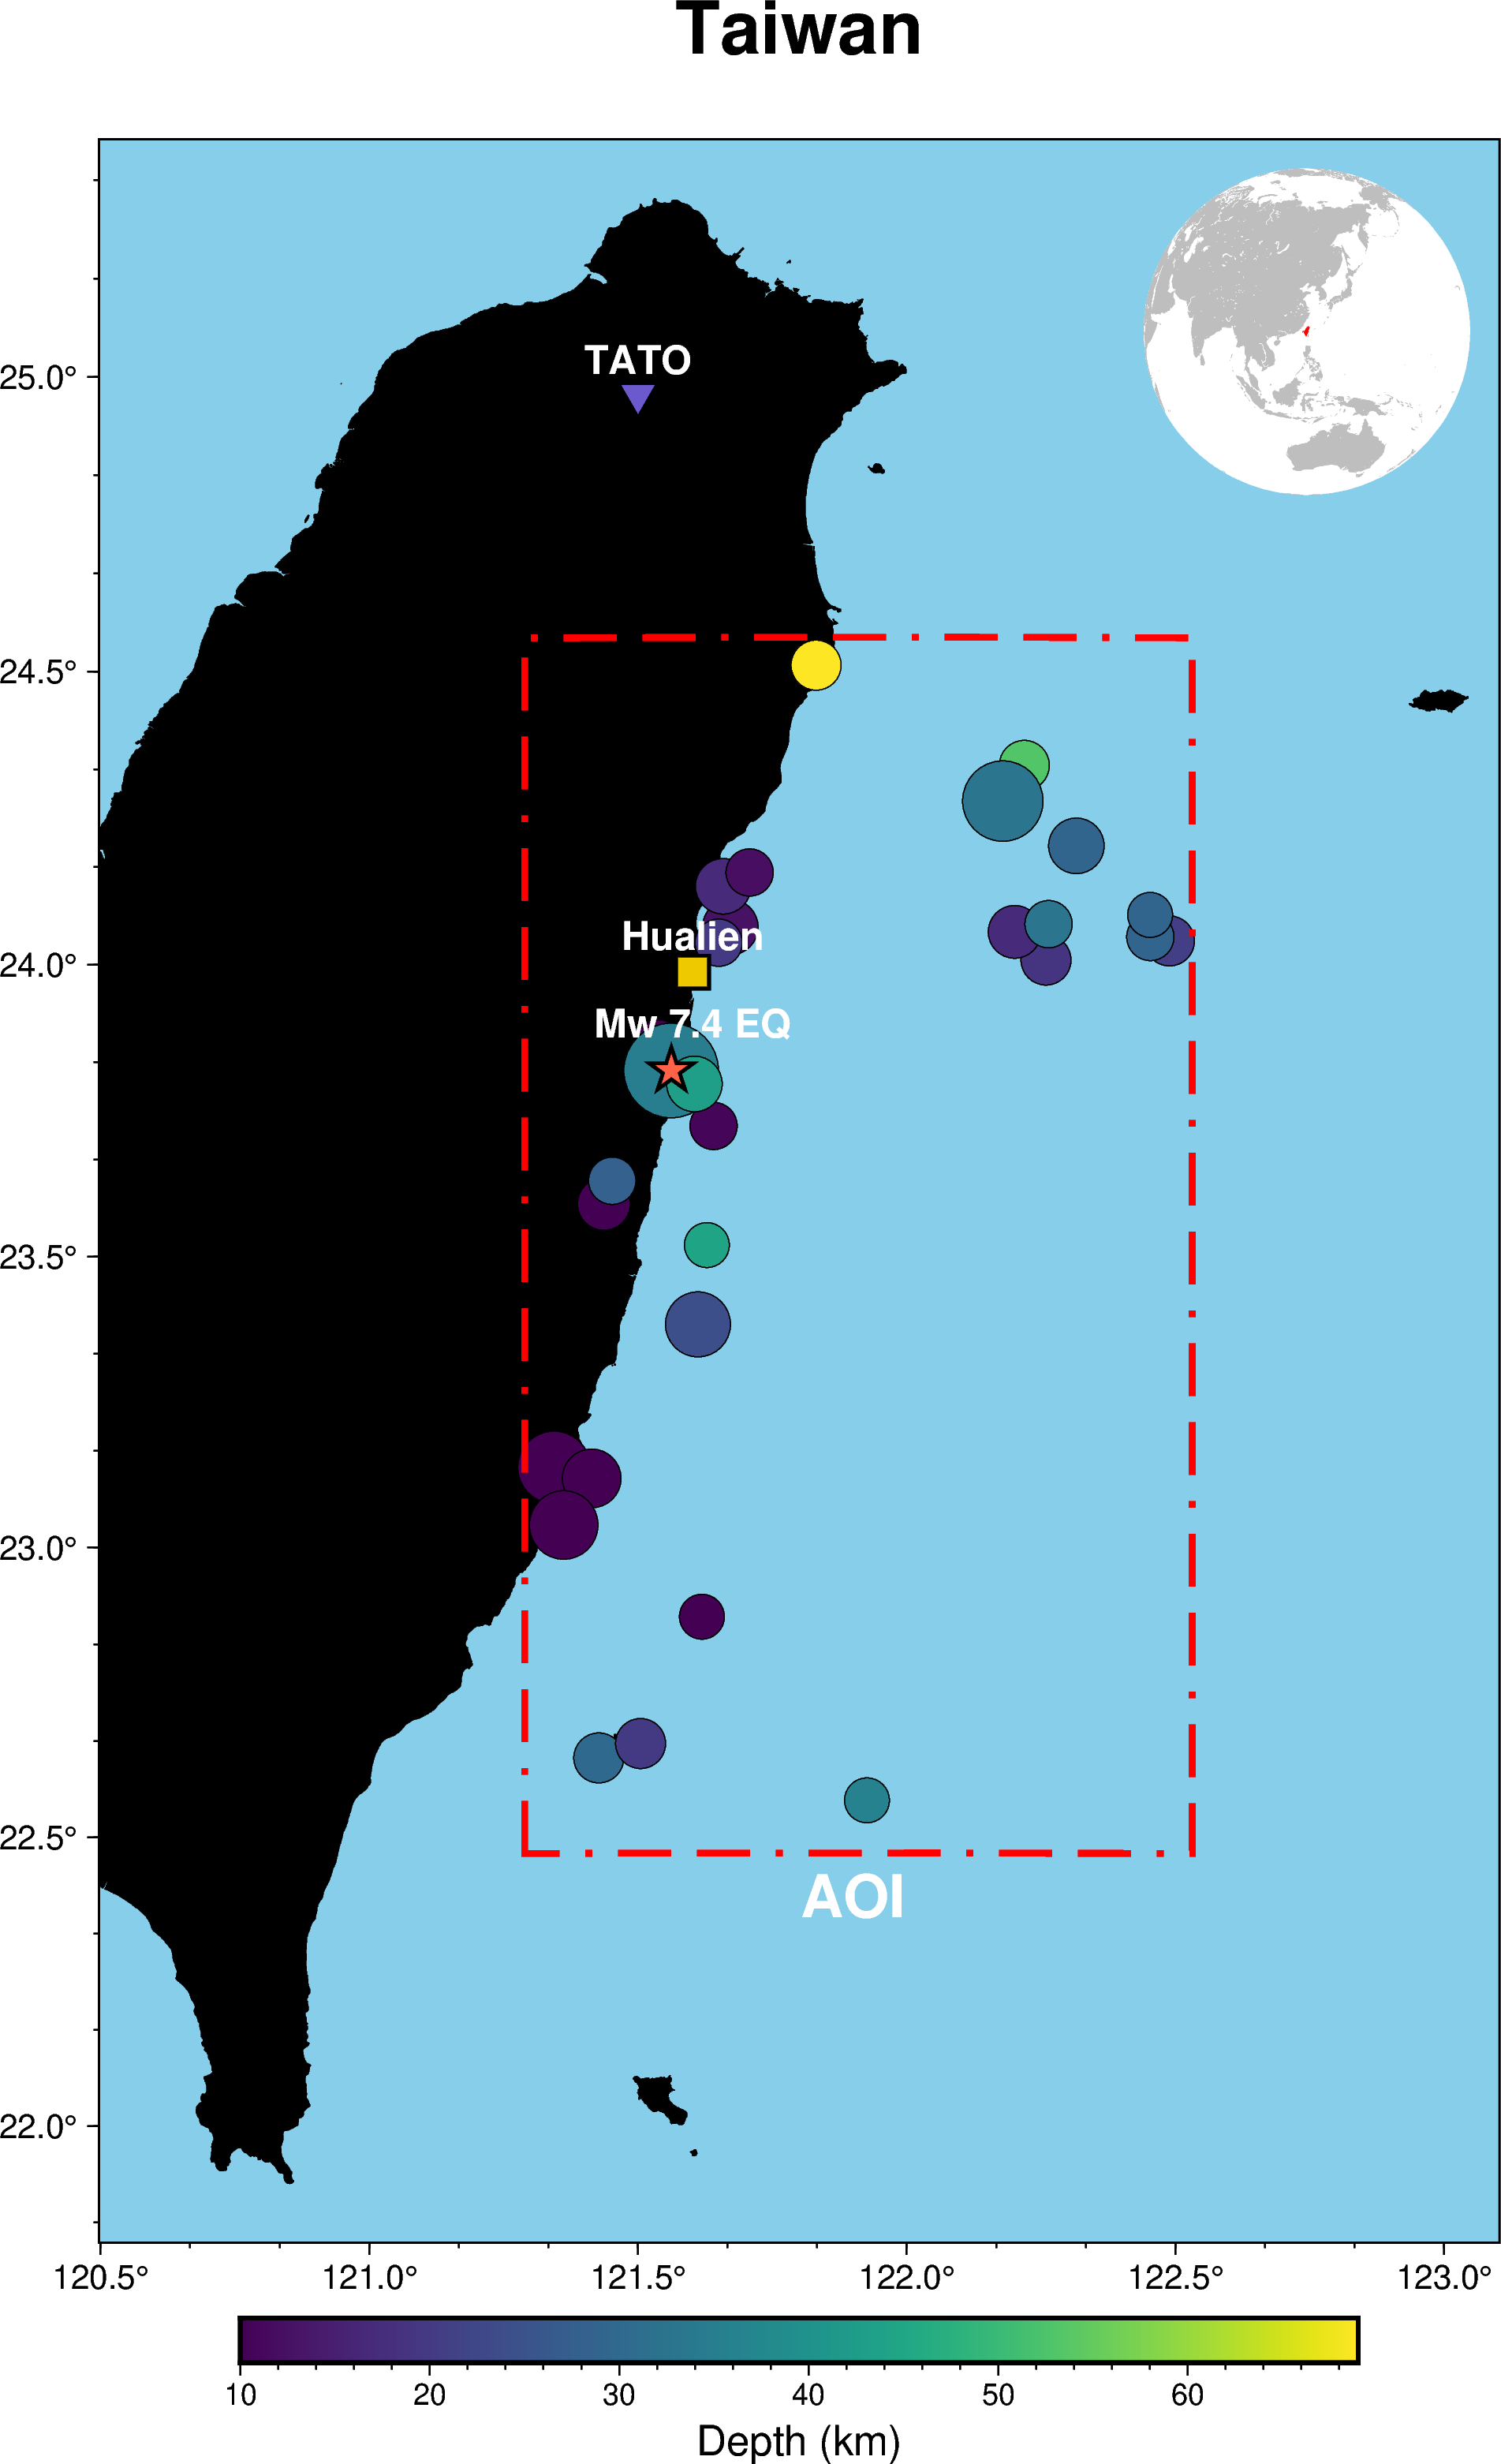

In [89]:
region = [120.5, 123.1, 21.8, 25.4]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.x', MAP_FRAME_TYPE='plain')
fig.basemap(region=region, projection ='M15c',frame=True)
fig.basemap(frame='+tTaiwan')
fig.coast(land='black', water='skyblue', borders=['2/0.5p,red'])
pygmt.makecpt(cmap="viridis", series=[Taiwan_big_eq['depth'].min(), Taiwan_big_eq['depth'].max()])
fig.plot(
    x=Taiwan_big_eq['longitude'],
    y=Taiwan_big_eq['latitude'], 
    size=0.02*(1.7**Taiwan_big_eq['mag']), 
    fill=Taiwan_big_eq['depth'],
    cmap=True, 
    style='cc',
    pen='black')
fig.colorbar(frame="xaf+lDepth (km)")
fig.plot(
    projection="M15c",
    x=[121.289, 121.289, 122.531, 122.531,121.289],
    y=[22.472, 24.557, 24.557, 22.472, 22.472],
    pen="2p,red,-.-",
)
fig.text(text="AOI", x=121.9, y=22.4, font="18p,Helvetica-Bold,white")
with fig.inset(
    position="jTR+w3.5c+o0.3c",
    margin=0):
    fig.coast(region="g",
              projection="G121/23.5/3.5c",
              land="gray",
              water="white",
              dcw="TW+gred"
    )

fig.plot(x=121.50, y=24.97, style="i0.5c", pen="1p,black", fill="slateblue")
fig.text(text="TATO",x=121.50, y=25.03, font='12p,Helvetica-Bold,white')
fig.plot(x=121.6016, y=23.9872, style="s0.5c", pen="1p,black", fill="gold2")
fig.text(text="Hualien",x=121.6016, y=24.05, font='12p,Helvetica-Bold,white')
fig.plot(x=121.562, y=23.819, style="a0.5c", pen="1p,black", fill="tomato")
fig.text(text="Mw 7.4 EQ",x=121.6016, y=23.9, font='12p,Helvetica-Bold,white')
fig.show()